# Testing model accuracy at predicting short, medium and long contacts

## Import .py file

In [1]:
# Set path to directory containing .py files
# Import .py file to extract distance between amino acids, contacts and attentions
# All necessary packages are imported within the .py file

import sys
sys.path.append("../py")

# ESM-2 model for protein embeddings is esm.pretrained.esm2_t33_650M_UR50D()
from extract_contact_aa_distance_attentions import * 


from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0-32): 33 x TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
  )
  (contact_head): ContactPredictionHead(
    (regression): Linear(in_features=660, out_features=1, bias=True)
    (activation): Sigmoid()
  )
  (emb_layer_norm_after): LayerNorm((1280,), eps=1

In [2]:
# Ignore warnings when importing PDB structure files
warnings.simplefilter('ignore', PDBConstructionWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Set variable for parsing PDB structural files
parser = PDBParser()  

## Extract Sequences from CASP7 Dataset

In [3]:
## Make sure to update directory paths from .py file prior to executing code

# Parse CASP training_95 file, extract all sequence IDs and sequences from dataset
# CASP training_95 file contains seed sequences for sequence clusters at 95% similarity

prot_data_dict = parse_casp7_file(casp_95)

for casp_id, casp_seq in list(prot_data_dict.items())[:3]:
    print(casp_id)
    print(casp_seq)
    print()

1RSO_2_B
GLLAAERAVSQVLDSLEEIHALTDSSEKDLDFLHSVFQDQHLHTLLDLYDKINTKS

3PCG_1_A
PIELLPETPSQTAGPYVHIGLALEAAGNPTRDQEIWNRLAKPDAPGEHILLLGQVYDGNGHLVRDSFLEVWQADANGEYQDAYNLENAFNSFGRTATTFDAGEWTLHTVKPGVVNNAAGVPMAPHINISLFARGINIHLHTRLYFDDEAQANAKCPVLNLIEQPQRRETLIAKRCEVDGKTAYRFDIRIQGEGETVFFDF

1YBD_1_A
MTQQIKYKRVLLKLSGESLMGSDPFGINHDTIVQTVGEIAEVVKMGVQVGIVVGGGNIFRGVSAQAGSMDRATADYMGMMATVMNALALKDAFETLGIKARVQSALSMQQIAETYARPKAIQYLEEGKVVIFAAGTGNPFFTTDTAAALRGAEMNCDVMLKATNVDGVYTADPKKDPSATRYETITFDEALLKNLKVMDATAFALCRERKLNIVVFGIAKEGSLKRVITGEDEGTLVHC



In [4]:
# CASP datasets contains sequence IDs that correspond to different chains in a sequence
# I.E. 1RSO_2_B refers to the 2nd part of chain B of the protein 1RSO

## To be sure I extract the CASP sequence that corresponds to the sequence in the 
# PDB structural file, I extract CASP IDs that occur once
# Which means that the stored sequence is the entire sequence for the protein
# This is because some sequences in the dataset only have a label for 1 chain

# Calculate occurence of sequence IDs
protein_id_counts = Counter(protein_id.split('_')[0] for protein_id in prot_data_dict)

# Store IDs that only occur once as single_occurence_ids
single_occurence_ids = [protein_id for protein_id, count in protein_id_counts.items() if count == 1]

print('Number of Unique IDs: ', len(single_occurence_ids), '\n')
print(single_occurence_ids[:5])

Number of Unique IDs:  8494 

['1YBD', '1PSM', '1DM0', '1WFO', '1YOA']


## Extract FASTA files from PDB database from identified CASP Protein IDs

In [5]:
## Take the IDs that occur once in the CASP training_95 dataset and extract the sequences
# from the PDB database. These sequences are used in generating PDB structural data.
# I.E. calculating arnstrong distance.

# for pdb_id in single_occurence_ids:
#     download_fasta(pdb_id, fasta_dir, downloadurl="https://www.rcsb.org/fasta/entry/")

# Load sequence ID and sequences from PDB into a dictionary
protein_data = load_fastas(fasta_dir)

print('Number of Sequences: ', len(protein_data), '\n')

for pdb_id, pdb_seq in list(protein_data.items())[:3]:
    print(pdb_id)
    print(pdb_seq)
    print()

Number of Sequences:  2682 

1C4R
GHAGTTYIFSKGGGQITYKWPPNDRPSTRADRLAIGFSTVQKEAVLVRVDSSSGLGDYLELHIHQGKIGVKFNVGTDDIAIEESNAIINDGKYHVVRFTRSGGNATLQVDSWPVIERYPAGRQLTIFNSQATIIIGGKEQGQPFQGQLSGLYYNGLKVLNMAAENDANIAIVGNVRLVGEVP

1UE8
MYDWFKQMRKESPVYYDGKVWNLFKYEDCKMVLNDHKRFSSNLTGYNDKLEMLRSGKVFFDIPTRYTMLTSDPPLHDELRNLTADAFNPSNLPVDFVREVTVKLLSELDEEFDVIESFAIPLPILVISKMLGINPDVKKVKDWSDLVALRLGRADEIFSIGRKYLELISFSKKELDSRKGKEIVDLTGKIANSNLSELEKEGYFILLMIAGNETTTNLIGNAIEDFTLYNSWDYVREKGALKAVEEALRFSPPVMRTIRVTKEKVKIRDQVIDEGELVRVWIASANRDEEVFKDPDSFIPDRTPNPHLSFGSGIHLCLGAPLARLEARIALEEFAKKFRVKEIVKKEKIDNEVLNGYRKLVVRVERT

1I24
MRGSHHHHHHGSRVMVIGGDGYCGWATALHLSKKNYEVCIVDNLVRRLFDHQLGLESLTPIASIHDRISRWKALTGKSIELYVGDICDFEFLAESFKSFEPDSVVHFGEQRSAPYSMIDRSRAVYTQHNNVIGTLNVLFAIKEFGEECHLVKLGTMGEYGTPNIDIEEGYITITHNGRTDTLPYPKQASSFYHLSKVHDSHNIAFTCKAWGIRATDLNQGVVYGVKTDETEMHEELRNRLDYDAVFGTALNRFCVQAAVGHPLTVYGKGGQTRGYLDIRDTVQCVEIAIANPAKAGEFRVFNQFTEQFSVNELASLVTKAGSKLGLDVKKMTVPNPRVEAEEHYYNAKHTKLMELGLEPHYLSDSLLDSLLNFAVQFKDRVDTKQIMPSVSWKKIGVKTKSMT

## Extract sequences that are the same in PDB database and CASP dataset

In [6]:
# Store sequence IDs that have sequences that are the same in both PDB database and
# CASP training_95 dataset
# Double checking if the sequences are uniform is important to ensure we are comparing
# the same proteins and chains that are the seed sequences in the CASP dataset clusters

same_sequence_ids = check_casp_pdb_seqs(protein_data)

print('Number of Uniform Sequences: ', len(same_sequence_ids), '\n')

Number of Uniform Sequences:  1215 



## Extract PDB structural data

In [ ]:
## Takes pdb_ids that have been extracted above and downloads the pdb structural file from
# the pdb database.
# These files will be used when generating contact sites.


# for pdb_id in same_sequence_ids:
#     download_pdb(pdb_id, structure_dir, downloadurl="http://files.rcsb.org/download/")



## Calculate distance between amino acids in the sequence and arnstrong distance between amino acids from PDB structural file

In [7]:
## To make sure we have a balanced number of contacts and non-contacts for each protein
# We make a subset of non-contact sites that are randomly selected and
# has the same number of amino acid pairs as in-contact sites

in_contact_sites, non_contact_sites, subset_non_contact_sites = contacts_per_pdb(same_sequence_ids,protein_data)

# Assuming in_contact_sites and subset_non_contact_sites are dictionaries
for sequence_id_in_contact, sequence_id_non_contact in zip(list(in_contact_sites.keys())[:1], list(subset_non_contact_sites.keys())[:1]):
    # If you want to process only 'in_contact_sites'
    for instance in random.sample(in_contact_sites[sequence_id_in_contact], 3):
        print(instance)

for instance in random.sample(subset_non_contact_sites[sequence_id_non_contact], 3):
    print(instance)


{'res_1': 252, 'res_2': 248, 'sig_1': 'P', 'sig_2': 'L', 'aa_dist': 4, 'arn_dist': 4.753109, 'in_contact': True}
{'res_1': 141, 'res_2': 138, 'sig_1': 'K', 'sig_2': 'K', 'aa_dist': 3, 'arn_dist': 4.9982476, 'in_contact': True}
{'res_1': 146, 'res_2': 143, 'sig_1': 'L', 'sig_2': 'W', 'aa_dist': 3, 'arn_dist': 4.9348, 'in_contact': True}
{'res_1': 182, 'res_2': 126, 'sig_1': 'E', 'sig_2': 'V', 'aa_dist': 56, 'arn_dist': 21.060047, 'in_contact': False}
{'res_1': 352, 'res_2': 28, 'sig_1': 'E', 'sig_2': 'D', 'aa_dist': 324, 'arn_dist': 21.56708, 'in_contact': False}
{'res_1': 300, 'res_2': 83, 'sig_1': 'P', 'sig_2': 'T', 'aa_dist': 217, 'arn_dist': 32.222168, 'in_contact': False}


In [20]:
# Store in_contact dictionary and subset of non_contact dictionary as a single dictionary
# which will be used in ML train/test split

# Some sequences chains that are found to have no contacts are removed from the dictionary

contact_data = generate_contact_data(in_contact_sites, subset_non_contact_sites)

print('Number of sequences: ', len(contact_data))

Number of sequences:  1102


## Collect X, y data for ML model training

In [9]:
# Randomly select sequences from same_sequence_ids to reduce computational demand for training
seed_value = 67
random.seed(seed_value)
n_sequences = 300

sequence_ids = random.sample(same_sequence_ids, n_sequences)
# sequence_ids = same_sequence_ids
print('n_sequences: ', n_sequences)
print(sequence_ids[:5])

n_sequences:  300
['1BUE', '1FK5', '1QK9', '1PPQ', '1T5Q']


In [10]:
class DataPoint:
    def __init__(self, id, X, y):
        self.id = id
        self.X = X
        self.y = y

In [11]:
ids = []
X = []
y = []
data_points = []  # List to hold DataPoint objects
iterations = 0

for pdb_id in sequence_ids:
    structure = parser.get_structure(pdb_id, os.path.join(structure_dir, f"{pdb_id}.pdb"))  # Correct path joining
    protein_structure = structure[0]
    chain = protein_structure['A']
    first_residue = list(chain.get_residues())[0].id[1]
    print('Iteration: ', iterations)
    iterations += 1
    if first_residue == 1:
        attention_data = generate_embeddings(pdb_id, protein_data)
        for i in contact_data[pdb_id]:
            id = [pdb_id, i['res_1'], i['res_2']]
            x = get_x_y(attention_data, i['res_1'], i['res_2'])
            data_points.append(DataPoint(id, x, i['in_contact']))
    else:
        continue

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Itera

In [86]:
len(test_X)

3234

In [12]:
from functools import partial

def nested_dict(n, type):
    if n == 1:
        return defaultdict(type)
    else:
        return defaultdict(partial(nested_dict, n-1, type))

# Create a 3-layer nested dictionary with the innermost layer as a dict


In [24]:
pulled_contact_data = nested_dict(3, dict)

# Add data from in_contact_sites
for pdb_id, contacts in in_contact_sites.items():
    for contact in contacts:
        res_1 = contact['res_1']
        res_2 = contact['res_2']
        pulled_contact_data[pdb_id][res_1][res_2] = {
            'sig_1': contact['sig_1'],
            'sig_2': contact['sig_2'],
            'aa_dist': int(contact['aa_dist']),
            'arn_dist': float(contact['arn_dist']),
            'in_contact': contact['in_contact']
        }

# Add data from subset_non_contact_sites
for pdb_id, non_contacts in subset_non_contact_sites.items():
    for non_contact in non_contacts:
        res_1 = non_contact['res_1']
        res_2 = non_contact['res_2']
        pulled_contact_data[pdb_id][res_1][res_2] = {
            'sig_1': non_contact['sig_1'],
            'sig_2': non_contact['sig_2'],
            'aa_dist': int(non_contact['aa_dist']),
            'arn_dist': float(non_contact['arn_dist']),
            'in_contact': non_contact['in_contact']
        }


In [14]:
pulled_contact_data['1UE8'][12][8]

{'sig_1': 'S',
 'sig_2': 'M',
 'aa_dist': 4,
 'arn_dist': 4.840004,
 'in_contact': True}

In [87]:
train_data, test_data = train_test_split(data_points, test_size=0.4, random_state=42)

# Extract X and y values from train_data
train_X = [dp.X for dp in train_data]
train_y = [dp.y for dp in train_data]
# Extract X and y values from test_data
test_X = [dp.X for dp in test_data]
test_y = [dp.y for dp in test_data]

In [129]:
def calculate_recall(tp, fn):
    return tp / (tp + fn) if (tp + fn) > 0 else 0

def calculate_precision(tp, fp):
    return tp / (tp + fp) if (tp + fp) > 0 else 0

def calculate_accuracy(tp, tn, total):
    return (tp + tn) / total if total != 0 else 0

## Random Forest Classifier

In [125]:

# Create and train the RandomForest model
model = RandomForestClassifier(criterion='gini', max_depth=8,max_features='sqrt',n_estimators = 1000,random_state=42)

model.fit(train_X, train_y)


RandomForestClassifier(max_depth=8, n_estimators=1000, random_state=42)

In [126]:
# Make predictions on the test set using the extracted features
y_pred = model.predict(test_X)


In [97]:
# # Model hyperparameters optimized using Grid-Search CV on 300 randomly selected sequences
# # 9,699 amino acid instances

# # Train Random Forest Classifier

# rf_clf = RandomForestClassifier(criterion='gini', max_depth=8,max_features='sqrt',n_estimators = 1000,random_state=42)
# rf_clf.fit(X_train, y_train)

In [127]:
accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)

print("Random Forest Accuracy:", accuracy)
print("Random Forest Precision:", precision)
print("Random Forest Recall:", recall)

Random Forest Accuracy: 0.8980980361837019
Random Forest Precision: 0.8896720809071407
Random Forest Recall: 0.9066208619612742


In [130]:
# Initialize counters for all categories
short_contact = short_true_preds = short_false_preds = short_true_negs = short_false_negs = 0
medium_contact = med_true_preds = med_false_preds = med_true_negs = med_false_negs = 0
long_contact = long_true_preds = long_false_preds = long_true_negs = long_false_negs = 0

for dp, pred in zip(test_data, y_pred):
    id_ = dp.id
    data = pulled_contact_data[id_[0]][id_[1]][id_[2]]
    is_positive_prediction = pred == 1
    is_positive_true = dp.y == 1

    if data['aa_dist'] <= 20:
        short_contact += 1
        if is_positive_prediction and is_positive_true:
            short_true_preds += 1
        elif is_positive_prediction and not is_positive_true:
            short_false_preds += 1
        elif not is_positive_prediction and not is_positive_true:
            short_true_negs += 1
        elif not is_positive_prediction and is_positive_true:
            short_false_negs += 1
    elif 20 < data['aa_dist'] <= 60:
        medium_contact += 1
        if is_positive_prediction and is_positive_true:
            med_true_preds += 1
        elif is_positive_prediction and not is_positive_true:
            med_false_preds += 1
        elif not is_positive_prediction and not is_positive_true:
            med_true_negs += 1
        elif not is_positive_prediction and is_positive_true:
            med_false_negs += 1
    elif data['aa_dist'] > 60:
        long_contact += 1
        if is_positive_prediction and is_positive_true:
            long_true_preds += 1
        elif is_positive_prediction and not is_positive_true:
            long_false_preds += 1
        elif not is_positive_prediction and not is_positive_true:
            long_true_negs += 1
        elif not is_positive_prediction and is_positive_true:
            long_false_negs += 1


In [131]:
print('Short Contacts: ', short_contact)
print('Medium Contacts: ', medium_contact)
print('Long Contacts: ', long_contact)
print()

print('Random Forest SML Predictions')
print('Short Accuracy: ', round(calculate_accuracy(short_true_preds, short_true_negs, short_contact) * 100, 2), '%')
print('Medium Accuracy: ', round(calculate_accuracy(med_true_preds, med_true_negs, medium_contact) * 100, 2), '%')
print('Long Accuracy: ', round(calculate_accuracy(long_true_preds, long_true_negs, long_contact) * 100, 2), '%')
print()

print('Short Recall: ', round(calculate_recall(short_true_preds, short_false_negs) * 100, 2), '%')
print('Medium Recall: ', round(calculate_recall(med_true_preds, med_false_negs) * 100, 2), '%')
print('Long Recall: ', round(calculate_recall(long_true_preds, long_false_negs) * 100, 2), '%')
print()

print('Short Precision: ', round(calculate_precision(short_true_preds, short_false_preds) * 100, 2), '%')
print('Medium Precision: ', round(calculate_precision(med_true_preds, med_false_preds) * 100, 2), '%')
print('Long Precision: ', round(calculate_precision(long_true_preds, long_false_preds) * 100, 2), '%')

Short Contacts:  2570
Medium Contacts:  1957
Long Contacts:  1940

SVC SML Predictions
Short Accuracy:  88.68 %
Medium Accuracy:  88.86 %
Long Accuracy:  92.27 %

Short Recall:  96.05 %
Medium Recall:  88.89 %
Long Recall:  70.9 %

Short Precision:  88.87 %
Medium Precision:  88.71 %
Long Precision:  90.34 %


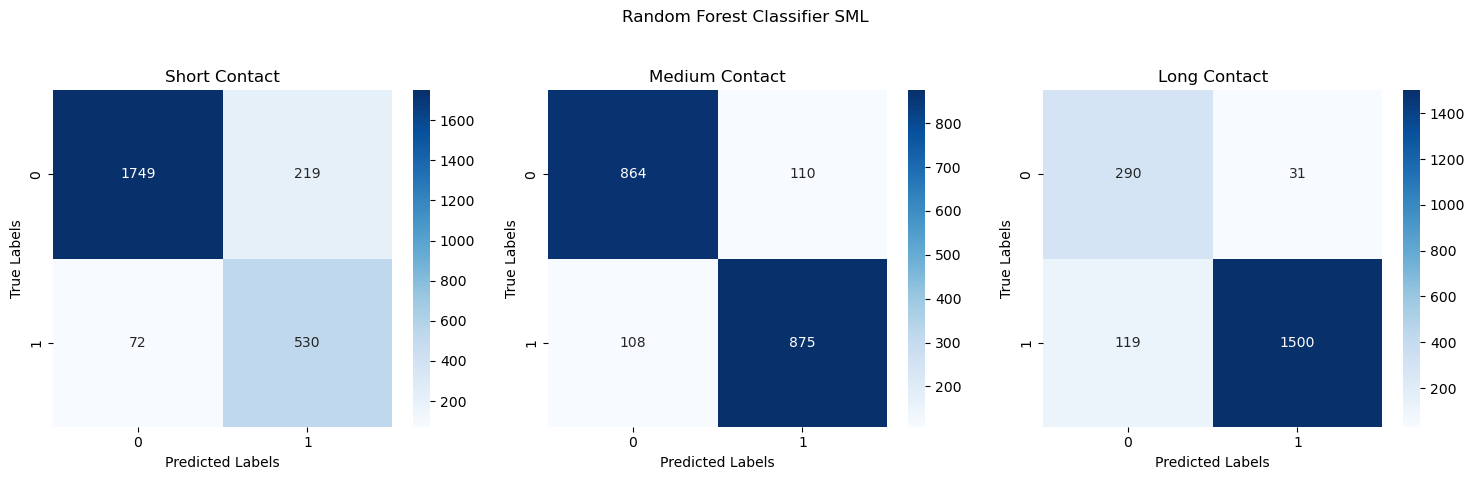

In [132]:
# Confusion matrices
conf_matrix_short = np.array([[short_true_preds, short_false_preds],
                              [short_false_negs, short_true_negs]])

conf_matrix_medium = np.array([[med_true_preds, med_false_preds],
                               [med_false_negs, med_true_negs]])

conf_matrix_long = np.array([[long_true_preds, long_false_preds],
                             [long_false_negs, long_true_negs]])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Random Forest Classifier SML')

# Plot each confusion matrix
sns.heatmap(conf_matrix_short, annot=True, fmt="d", ax=axes[0], cmap='Blues')
axes[0].set_title('Short Contact')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(conf_matrix_medium, annot=True, fmt="d", ax=axes[1], cmap='Blues')
axes[1].set_title('Medium Contact')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

sns.heatmap(conf_matrix_long, annot=True, fmt="d", ax=axes[2], cmap='Blues')
axes[2].set_title('Long Contact')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Linear SVC

In [133]:
# Model hyperparameters optimized using Grid-Search CV on 300 randomly selected sequences
# 9,699 amino acid instances

# Train Linear SVC

linear_svc = LinearSVC(C=10, class_weight='balanced', dual=True, loss='hinge',max_iter=200000)
linear_svc.fit(train_X, train_y)
y_pred = linear_svc.predict(test_X)

In [134]:
accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)

print("SVC Accuracy:", accuracy)
print("SVC Precision:", precision)
print("SVC Recall:", recall)

SVC Accuracy: 0.8837173341580331
SVC Precision: 0.921251719394773
SVC Recall: 0.8366645846346034


In [136]:
# Initialize counters for all categories
short_contact = short_true_preds = short_false_preds = short_true_negs = short_false_negs = 0
medium_contact = med_true_preds = med_false_preds = med_true_negs = med_false_negs = 0
long_contact = long_true_preds = long_false_preds = long_true_negs = long_false_negs = 0

for dp, pred in zip(test_data, y_pred):
    id_ = dp.id
    data = pulled_contact_data[id_[0]][id_[1]][id_[2]]
    is_positive_prediction = pred == 1
    is_positive_true = dp.y == 1

    if data['aa_dist'] <= 20:
        short_contact += 1
        if is_positive_prediction and is_positive_true:
            short_true_preds += 1
        elif is_positive_prediction and not is_positive_true:
            short_false_preds += 1
        elif not is_positive_prediction and not is_positive_true:
            short_true_negs += 1
        elif not is_positive_prediction and is_positive_true:
            short_false_negs += 1
    elif 20 < data['aa_dist'] <= 60:
        medium_contact += 1
        if is_positive_prediction and is_positive_true:
            med_true_preds += 1
        elif is_positive_prediction and not is_positive_true:
            med_false_preds += 1
        elif not is_positive_prediction and not is_positive_true:
            med_true_negs += 1
        elif not is_positive_prediction and is_positive_true:
            med_false_negs += 1
    elif data['aa_dist'] > 60:
        long_contact += 1
        if is_positive_prediction and is_positive_true:
            long_true_preds += 1
        elif is_positive_prediction and not is_positive_true:
            long_false_preds += 1
        elif not is_positive_prediction and not is_positive_true:
            long_true_negs += 1
        elif not is_positive_prediction and is_positive_true:
            long_false_negs += 1


In [138]:
print('Short Contacts: ', short_contact)
print('Medium Contacts: ', medium_contact)
print('Long Contacts: ', long_contact)
print()

print('SVC SML Predictions')
print('Short Accuracy: ', round(calculate_accuracy(short_true_preds, short_true_negs, short_contact) * 100, 2), '%')
print('Medium Accuracy: ', round(calculate_accuracy(med_true_preds, med_true_negs, medium_contact) * 100, 2), '%')
print('Long Accuracy: ', round(calculate_accuracy(long_true_preds, long_true_negs, long_contact) * 100, 2), '%')
print()

print('Short Recall: ', round(calculate_recall(short_true_preds, short_false_negs) * 100, 2), '%')
print('Medium Recall: ', round(calculate_recall(med_true_preds, med_false_negs) * 100, 2), '%')
print('Long Recall: ', round(calculate_recall(long_true_preds, long_false_negs) * 100, 2), '%')
print()

print('Short Precision: ', round(calculate_precision(short_true_preds, short_false_preds) * 100, 2), '%')
print('Medium Precision: ', round(calculate_precision(med_true_preds, med_false_preds) * 100, 2), '%')
print('Long Precision: ', round(calculate_precision(long_true_preds, long_false_preds) * 100, 2), '%')

Short Contacts:  2570
Medium Contacts:  1957
Long Contacts:  1940

SVC SML Predictions
Short Accuracy:  86.89 %
Medium Accuracy:  87.94 %
Long Accuracy:  90.77 %

Short Recall:  89.57 %
Medium Recall:  82.61 %
Long Recall:  59.9 %

Short Precision:  91.73 %
Medium Precision:  92.3 %
Long Precision:  94.23 %


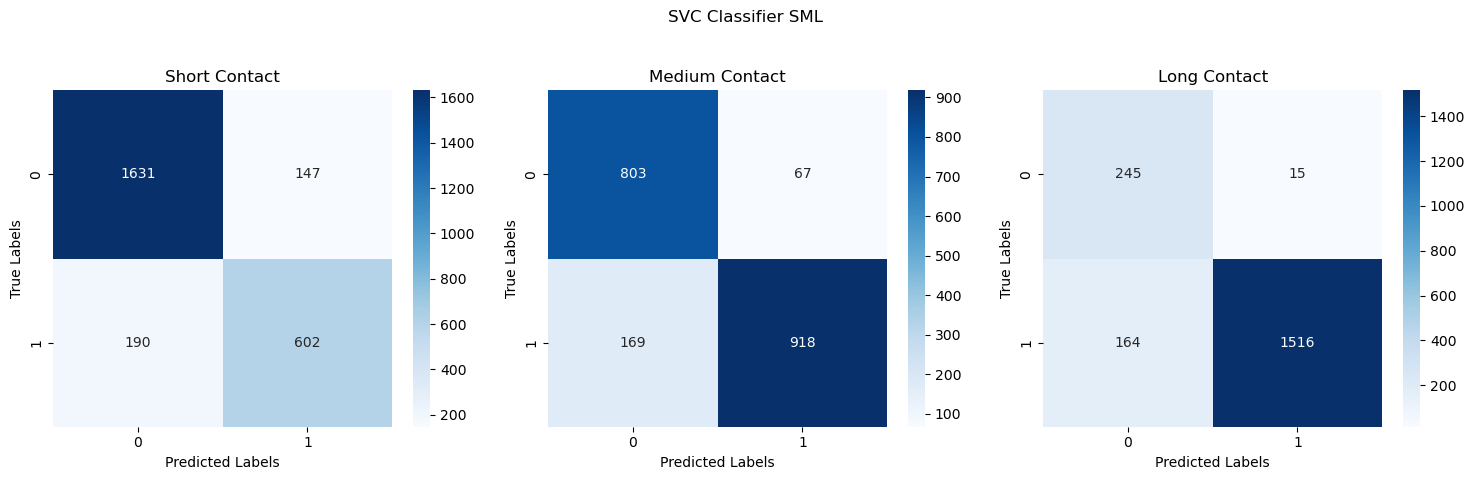

In [139]:
# Confusion matrices
conf_matrix_short = np.array([[short_true_preds, short_false_preds],
                              [short_false_negs, short_true_negs]])

conf_matrix_medium = np.array([[med_true_preds, med_false_preds],
                               [med_false_negs, med_true_negs]])

conf_matrix_long = np.array([[long_true_preds, long_false_preds],
                             [long_false_negs, long_true_negs]])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('SVC Classifier SML')

# Plot each confusion matrix
sns.heatmap(conf_matrix_short, annot=True, fmt="d", ax=axes[0], cmap='Blues')
axes[0].set_title('Short Contact')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(conf_matrix_medium, annot=True, fmt="d", ax=axes[1], cmap='Blues')
axes[1].set_title('Medium Contact')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

sns.heatmap(conf_matrix_long, annot=True, fmt="d", ax=axes[2], cmap='Blues')
axes[2].set_title('Long Contact')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Logistic Regression

In [140]:
# Model hyperparameters optimized using Grid-Search CV on 300 randomly selected sequences
# 9,699 amino acid instances

# Train Logistic Regression

lr_clf = LogisticRegression(C=100, max_iter=200000, solver='saga')
lr_clf.fit(train_X, train_y)
y_pred = lr_clf.predict(test_X)

In [141]:
accuracy = accuracy_score(test_y, y_pred)
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)

print("Logistic Regression Accuracy:", accuracy)
print("Logistic Regression Precision:", precision)
print("Logistic Regression Recall:", recall)

Logistic Regression Accuracy: 0.8770681923612185
Logistic Regression Precision: 0.9160041479433114
Logistic Regression Recall: 0.8276077451592755


In [142]:
# Initialize counters for all categories
short_contact = short_true_preds = short_false_preds = short_true_negs = short_false_negs = 0
medium_contact = med_true_preds = med_false_preds = med_true_negs = med_false_negs = 0
long_contact = long_true_preds = long_false_preds = long_true_negs = long_false_negs = 0

for dp, pred in zip(test_data, y_pred):
    id_ = dp.id
    data = pulled_contact_data[id_[0]][id_[1]][id_[2]]
    is_positive_prediction = pred == 1
    is_positive_true = dp.y == 1

    if data['aa_dist'] <= 20:
        short_contact += 1
        if is_positive_prediction and is_positive_true:
            short_true_preds += 1
        elif is_positive_prediction and not is_positive_true:
            short_false_preds += 1
        elif not is_positive_prediction and not is_positive_true:
            short_true_negs += 1
        elif not is_positive_prediction and is_positive_true:
            short_false_negs += 1
    elif 20 < data['aa_dist'] <= 60:
        medium_contact += 1
        if is_positive_prediction and is_positive_true:
            med_true_preds += 1
        elif is_positive_prediction and not is_positive_true:
            med_false_preds += 1
        elif not is_positive_prediction and not is_positive_true:
            med_true_negs += 1
        elif not is_positive_prediction and is_positive_true:
            med_false_negs += 1
    elif data['aa_dist'] > 60:
        long_contact += 1
        if is_positive_prediction and is_positive_true:
            long_true_preds += 1
        elif is_positive_prediction and not is_positive_true:
            long_false_preds += 1
        elif not is_positive_prediction and not is_positive_true:
            long_true_negs += 1
        elif not is_positive_prediction and is_positive_true:
            long_false_negs += 1


In [143]:
print('Short Contacts: ', short_contact)
print('Medium Contacts: ', medium_contact)
print('Long Contacts: ', long_contact)
print()

print('Logistic Regression SML Predictions')
print('Short Accuracy: ', round(calculate_accuracy(short_true_preds, short_true_negs, short_contact) * 100, 2), '%')
print('Medium Accuracy: ', round(calculate_accuracy(med_true_preds, med_true_negs, medium_contact) * 100, 2), '%')
print('Long Accuracy: ', round(calculate_accuracy(long_true_preds, long_true_negs, long_contact) * 100, 2), '%')
print()

print('Short Recall: ', round(calculate_recall(short_true_preds, short_false_negs) * 100, 2), '%')
print('Medium Recall: ', round(calculate_recall(med_true_preds, med_false_negs) * 100, 2), '%')
print('Long Recall: ', round(calculate_recall(long_true_preds, long_false_negs) * 100, 2), '%')
print()

print('Short Precision: ', round(calculate_precision(short_true_preds, short_false_preds) * 100, 2), '%')
print('Medium Precision: ', round(calculate_precision(med_true_preds, med_false_preds) * 100, 2), '%')
print('Long Precision: ', round(calculate_precision(long_true_preds, long_false_preds) * 100, 2), '%')

Short Contacts:  2570
Medium Contacts:  1957
Long Contacts:  1940

Logistic Regression SML Predictions
Short Accuracy:  85.76 %
Medium Accuracy:  87.89 %
Long Accuracy:  90.1 %

Short Recall:  88.47 %
Medium Recall:  82.92 %
Long Recall:  56.97 %

Short Precision:  91.17 %
Medium Precision:  91.9 %
Long Precision:  93.57 %


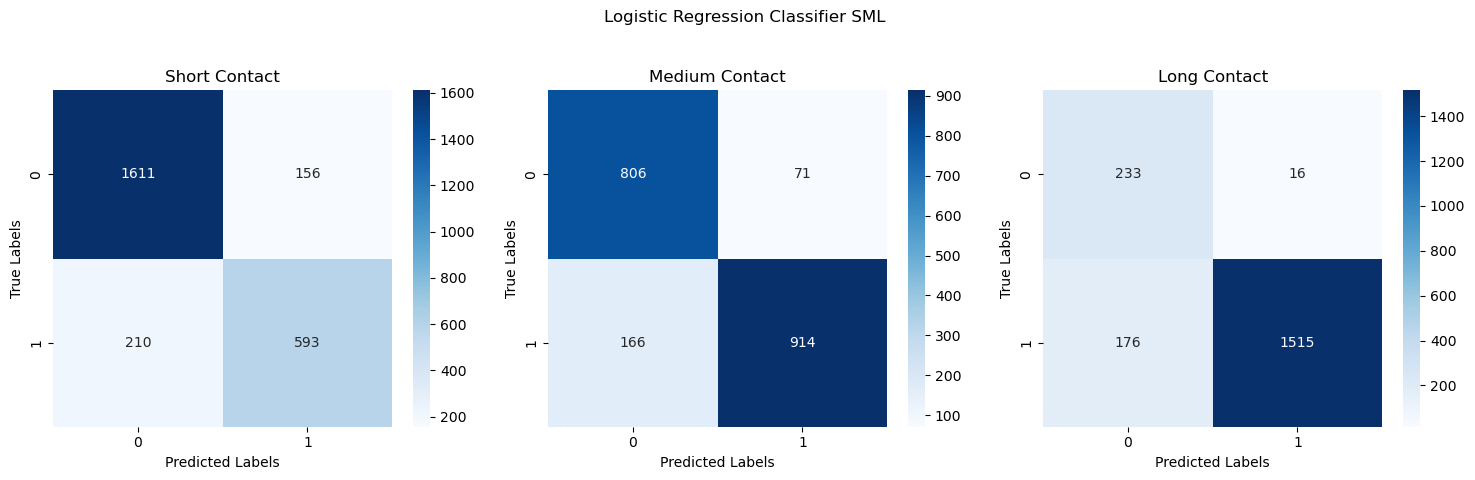

In [144]:
# Confusion matrices
conf_matrix_short = np.array([[short_true_preds, short_false_preds],
                              [short_false_negs, short_true_negs]])

conf_matrix_medium = np.array([[med_true_preds, med_false_preds],
                               [med_false_negs, med_true_negs]])

conf_matrix_long = np.array([[long_true_preds, long_false_preds],
                             [long_false_negs, long_true_negs]])

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
fig.suptitle('Logistic Regression Classifier SML')

# Plot each confusion matrix
sns.heatmap(conf_matrix_short, annot=True, fmt="d", ax=axes[0], cmap='Blues')
axes[0].set_title('Short Contact')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(conf_matrix_medium, annot=True, fmt="d", ax=axes[1], cmap='Blues')
axes[1].set_title('Medium Contact')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

sns.heatmap(conf_matrix_long, annot=True, fmt="d", ax=axes[2], cmap='Blues')
axes[2].set_title('Long Contact')
axes[2].set_xlabel('Predicted Labels')
axes[2].set_ylabel('True Labels')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()